In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
#
# model function
#
def h_x(Beta, X):
#
# calculate the matrix dot product of X and the Thetas
#
    return np.dot(Beta, X).flatten()

In [3]:
#
# cost function
#
def J_beta(pred, true):
#
# mean squared error
#
    return np.mean((pred - true) ** 2)

In [4]:
#
# update function
#
def update(pred, true, X, gamma):
    return gamma * np.sum((true - pred) * X, axis = 1)

In [5]:
#
# load the data
#
df = pd.read_csv('synth_temp.csv')

In [6]:
#
# slice 1902 and forward
#
df = df.loc[df.Year > 1901]

In [7]:
#
# roll up by year
#
df_group_year = df.groupby(['Year']).agg({'RgnAvTemp' : 'mean'})

In [8]:
#
# add the Year column so we can use that in a model
#
df_group_year['Year'] = df_group_year.index
df_group_year = df_group_year.rename(columns = {'RgnAvTemp' : 'AvTemp'})

In [9]:
#
# scale the data and add the X0 series
#
X_min = df_group_year.Year.min()
X_range = df_group_year.Year.max() - df_group_year.Year.min()
#
Y_min = df_group_year.AvTemp.min()
Y_range = df_group_year.AvTemp.max() - df_group_year.AvTemp.min()
#
scale_X = (df_group_year.Year - X_min) / X_range
train_X = pd.DataFrame({'X0' : np.ones(df_group_year.shape[0]), 
                        'X1' : scale_X}).transpose()
#
train_Y = (df_group_year.AvTemp - Y_min) / Y_range

In [10]:
print(train_X.iloc[:, :5])
print(train_Y[:5])

Year  1902      1903      1904      1905      1906
X0     1.0  1.000000  1.000000  1.000000  1.000000
X1     0.0  0.009259  0.018519  0.027778  0.037037
Year
1902    0.114676
1903    0.058017
1904    0.056296
1905    0.265110
1906    0.115164
Name: AvTemp, dtype: float64


In [11]:
#
# initialize Beta and the learning rate gamma
#
np.random.seed(42)
Beta = np.random.randn(2).reshape((1, 2)) * 0.1
print('initial Beta\n', Beta)
gamma = 0.0005
max_epochs = 100

initial Beta
 [[ 0.04967142 -0.01382643]]


In [12]:
y_pred = h_x(Beta, train_X)
print('Initial cost J(Beta) = ' + str(J_beta(y_pred, train_Y)))

Initial cost J(Beta) = 0.18849128813354338


In [13]:
epochs = []
costs = []
for epoch in range(max_epochs):
    Beta += update(y_pred, train_Y, train_X, gamma)
    y_pred = h_x(Beta, train_X)
    cost = J_beta(y_pred, train_Y)
    if epoch % 10 == 0:
        print('New cost J(Beta) = ' + str(round(cost, 3)) + 
              ' at epoch ' + str(epoch))
    epochs.append(epoch)
    costs.append(cost)

New cost J(Beta) = 0.171 at epoch 0
New cost J(Beta) = 0.083 at epoch 10
New cost J(Beta) = 0.06 at epoch 20
New cost J(Beta) = 0.052 at epoch 30
New cost J(Beta) = 0.048 at epoch 40
New cost J(Beta) = 0.046 at epoch 50
New cost J(Beta) = 0.043 at epoch 60
New cost J(Beta) = 0.041 at epoch 70
New cost J(Beta) = 0.039 at epoch 80
New cost J(Beta) = 0.037 at epoch 90


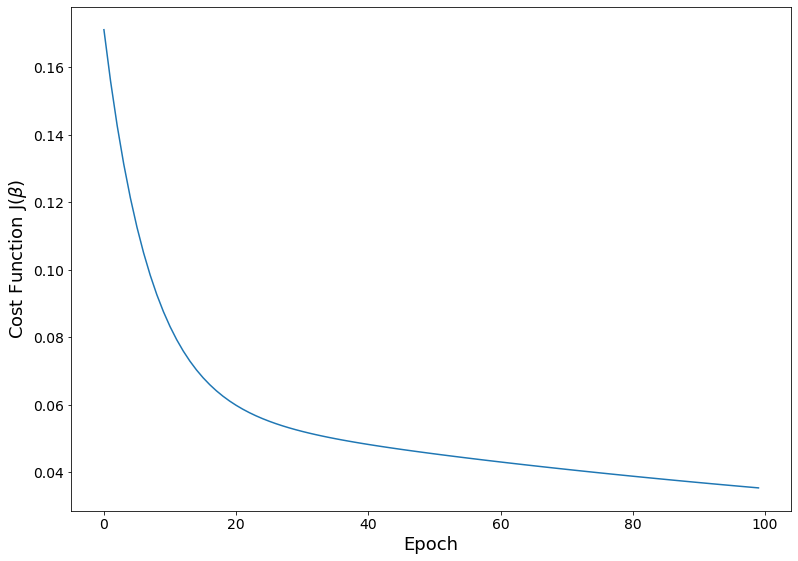

In [14]:
#
# plot training history
#
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
ax.plot(epochs, costs)
ax.tick_params(labelsize = 14)
ax.set_ylabel('Cost Function J(' + r'$\beta$' + ')',
               fontsize = 18)
ax.set_xlabel('Epoch', fontsize = 18)
plt.show()

In [15]:
#
# calcualte the r squared value
#
r2 = r2_score(train_Y, y_pred)
print('r squared = ', r2)

r squared =  0.5488427996385263


In [16]:
#
# generate predictions for visualization
#
pred_X = train_X
#
# make predictions
#
pred_Y = h_x(Beta, pred_X)
#
# scale predictions back to real values
#
pred_Y = (pred_Y * Y_range) + Y_min
#
# replace the X with the original values
#
pred_X = df_group_year['Year']

In [17]:
#
# scale the coefficients back to real values
#
Beta0 = (Y_min + 
         Y_range * Beta[0, 0] - 
         Y_range * Beta[0, 1] * X_min / X_range)
Beta1 = Y_range * Beta[0, 1] / X_range

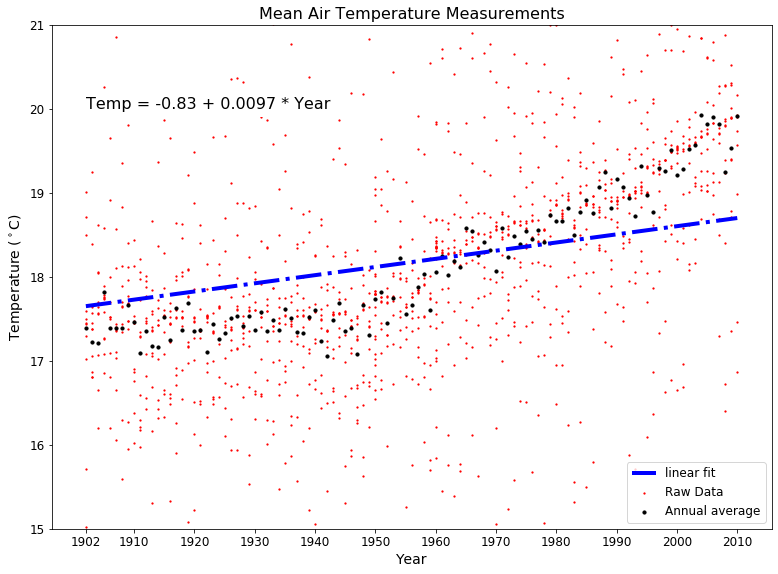

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
raw_plot_data = df
ax.scatter(raw_plot_data.Year, 
           raw_plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red',
           s = 1.5)
#
# Annual averages
#
ax.scatter(df_group_year.Year, 
           df_group_year.AvTemp, 
           label = 'Annual average', 
           c = 'k',
           s = 10)
#
# linear fit
#
ax.plot(pred_X, pred_Y, 
        c = "blue",
        linestyle = '-.',
        linewidth = 4,
        label = 'linear fit')
#
# put the model on the plot
#
ax.text(1902, 20,
        'Temp = ' + 
        str(round(Beta0, 2)) +
        ' + ' +
        str(round(Beta1, 4)) +
        ' * Year',
        fontsize = 16,
        backgroundcolor = 'white')
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(15, 21)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)
plt.show()